In [13]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
import random

# Initial configuration
height = 150
width = 150
batch_size = 64
seed = 100

# Ensure reproducibility
torch.manual_seed(seed)
random.seed(seed)

# Main dataset path
dataset_path = "./MY_data"
train_path = os.path.join(dataset_path, "train")
test_path = os.path.join(dataset_path, "test")
predict_path = os.path.join(dataset_path, "predict")

# Ensure CUDA device is set up
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using: {device}")

# Check if the dataset is already downloaded
if not os.path.exists(train_path) or not os.path.exists(test_path) or not os.path.exists(predict_path):
    print("Dataset not found, downloading...")
    os.system("kaggle datasets download -d karimabdulnabi/fruit-classification10-class -p ./ --unzip")
    print(f"Dataset downloaded at: {dataset_path}")
else:
    print("The dataset is already downloaded.")


Using: cuda
The dataset is already downloaded.


In [14]:
import os
from torchvision.datasets import ImageFolder
from collections import Counter


# Load datasets
train_data = ImageFolder(root=train_path)
test_data = ImageFolder(root=test_path)

# Count images per class in the training set
train_classes = [label for _, label in train_data.samples]
train_counts = Counter(train_classes)

# Count images per class in the test set
test_classes = [label for _, label in test_data.samples]
test_counts = Counter(test_classes)

# Print results
print("Number of images per class in the training set:")
for class_idx, count in train_counts.items():
    print(f"Class {train_data.classes[class_idx]}: {count} images")

print("\nNumber of images per class in the test set:")
for class_idx, count in test_counts.items():
    print(f"Class {test_data.classes[class_idx]}: {count} images")


Number of images per class in the training set:
Class apple: 301 images
Class avocado: 300 images
Class banana: 323 images
Class cherry: 326 images
Class kiwi: 322 images
Class mango: 303 images
Class orange: 303 images
Class pinenapple: 283 images
Class strawberries: 299 images
Class watermelon: 305 images

Number of images per class in the test set:
Class apple: 59 images
Class avocado: 43 images
Class banana: 52 images
Class cherry: 49 images
Class kiwi: 53 images
Class mango: 72 images
Class orange: 64 images
Class pinenapple: 67 images
Class stawberries: 74 images
Class watermelon: 41 images


Using: cuda
Epoch 1/20, Train Loss: 1.4838, Train Accuracy: 65.12%, Validation Loss: 0.3887, Validation Accuracy: 88.85%
Best model saved.
Epoch 2/20, Train Loss: 0.4232, Train Accuracy: 88.52%, Validation Loss: 0.2460, Validation Accuracy: 92.33%
Best model saved.
Epoch 3/20, Train Loss: 0.2507, Train Accuracy: 92.69%, Validation Loss: 0.2378, Validation Accuracy: 92.86%
Best model saved.
Epoch 4/20, Train Loss: 0.2076, Train Accuracy: 93.80%, Validation Loss: 0.1846, Validation Accuracy: 93.90%
Best model saved.
Epoch 5/20, Train Loss: 0.1751, Train Accuracy: 94.62%, Validation Loss: 0.1951, Validation Accuracy: 94.25%
No improvement for 1 consecutive epochs.
Epoch 6/20, Train Loss: 0.1670, Train Accuracy: 94.65%, Validation Loss: 0.1712, Validation Accuracy: 94.60%
Best model saved.
Epoch 7/20, Train Loss: 0.1485, Train Accuracy: 95.37%, Validation Loss: 0.1862, Validation Accuracy: 94.77%
No improvement for 1 consecutive epochs.
Epoch 8/20, Train Loss: 0.1404, Train Accuracy: 95.63

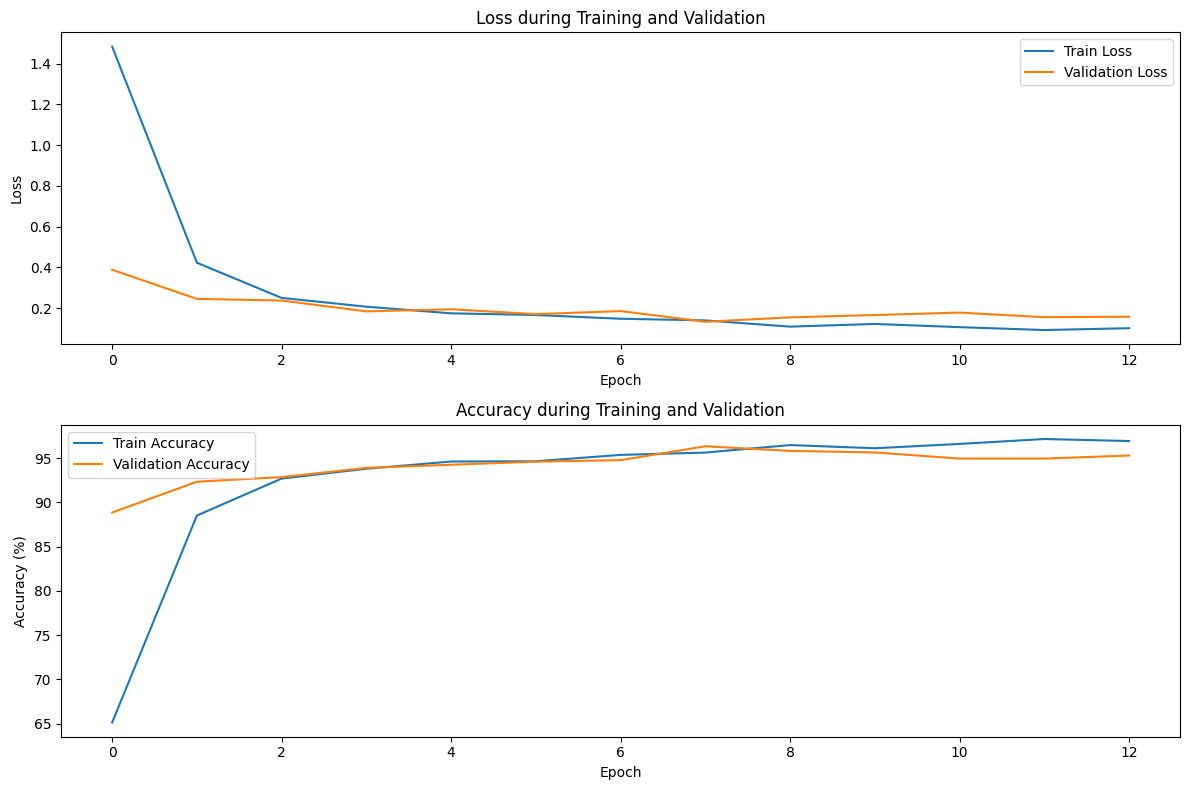

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import transforms, models
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder

# Initial configuration
height, width = 224, 224  # Compatible size with ResNet18
batch_size = 64
num_classes = 10  
seed = 100

# Ensure reproducibility
torch.manual_seed(seed)

# Device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using: {device}")

# Image transformations (scaling, normalization)
transform = transforms.Compose([
    transforms.Resize((height, width)),   # Resize images
    transforms.ToTensor(),               # Convert images to tensors
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Data augmentation
transform_train = transforms.Compose([
    transforms.RandomResizedCrop((height, width)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])


# Load datasets
train_data = ImageFolder(root=train_path, transform=transform_train)
test_data = ImageFolder(root=test_path, transform=transform)
# DataLoaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Load pre-trained model
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Lists to track metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Variables to track the best model
best_val_loss = float('inf')
patience = 5
trigger_times = 0

# Training loop
epochs = 20
for epoch in range(epochs):
    # Modo de entrenamiento
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation mode
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / len(test_loader)
    scheduler.step(val_loss)
    val_accuracy = 100 * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch + 1}/{epochs}, "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_times = 0
        torch.save(model.state_dict(), "best_model.pth")
        print("Best model saved.")
    else:
        trigger_times += 1
        print(f"No improvement for {trigger_times} consecutive epochs.")
        if trigger_times >= patience:
            print("Early stopping activated.")
            break

model.load_state_dict(torch.load("best_model.pth", weights_only=True))
model = model.to(device)
print("Best model weights loaded.")
# Plot metrics
plt.figure(figsize=(12, 8))

# Loss plot
plt.subplot(2, 1, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Loss during Training and Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Accuracy plot
plt.subplot(2, 1, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.title("Accuracy during Training and Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.tight_layout()
plt.show()

Accuracy of the model on the test images: 96.34%


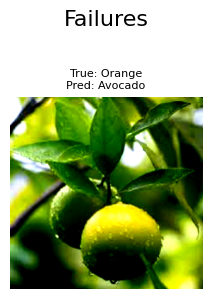

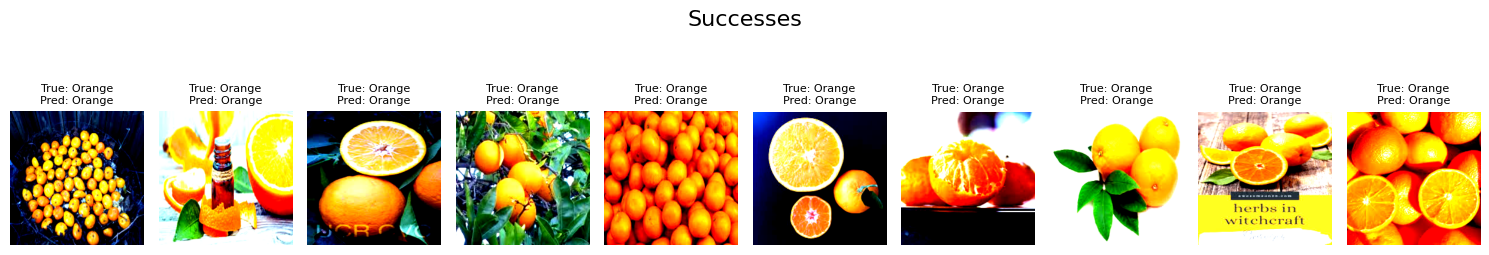

In [25]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

species_to_check = 6  # * index of the desired class to check
class_names = ['Apple', 'Avocado', 'Banana', 'Cherry', 'Kiwi', 'Mango', 'Orange', 'Pineapple', 'StrawBerries', 'Watermelon']

# Move the model to the GPU if necessary
model = model.to(device)

correct = 0
total = 0

# Lists to store images that failed and succeeded
results = {
    "failed": [],
    "correct": []
}

# Set the model to evaluation mode
model.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        
        # Get predictions
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Store images based on results
        for i in range(len(labels)):
            if labels[i].item() == species_to_check:   # Check if it matches the selected species
                if predicted[i] != labels[i]:
                    results["failed"].append((images[i].cpu(), labels[i].cpu(), predicted[i].cpu()))
                else:
                    results["correct"].append((images[i].cpu(), labels[i].cpu(), predicted[i].cpu()))

# Check that total is not zero
if total > 0:
    print(f'Accuracy of the model on the test images: {100 * correct / total:.2f}%')
else:
    print('No test images found.')

# Function to display images
def show_images(images, titles, num_to_display=10, title=''):
    num_images = min(num_to_display, len(images))
    cols = min(10, num_images)
    rows = (num_images + cols - 1) // cols
    
    plt.figure(figsize=(15, 3 * rows))
    for i in range(num_images):
        plt.subplot(rows, cols, i + 1)
        
        image = images[i]
        image = (image + 1) / 2  
        image = torch.clamp(image, 0, 1)
        plt.title(titles[i], fontsize=8)
        
        plt.imshow(image.permute(1, 2, 0)) 
        plt.axis('off')
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


# Display failed images
if results["failed"]:
    failed_images, failed_labels, failed_predictions = zip(*results["failed"])
    show_images(failed_images, 
                [f'True: {class_names[l.item()]}\nPred: {class_names[p.item()]}' for l, p in zip(failed_labels, failed_predictions)], 
                title='Failures')
else:
    print("No failed images found.")

# Display correct images
if results["correct"]:
    correct_images, correct_labels, correct_predictions = zip(*results["correct"])
    show_images(correct_images, 
                [f'True: {class_names[l.item()]}\nPred: {class_names[p.item()]}' for l, p in zip(correct_labels, correct_predictions)], 
                title='Successes')
else:
    print("No correct images found.")


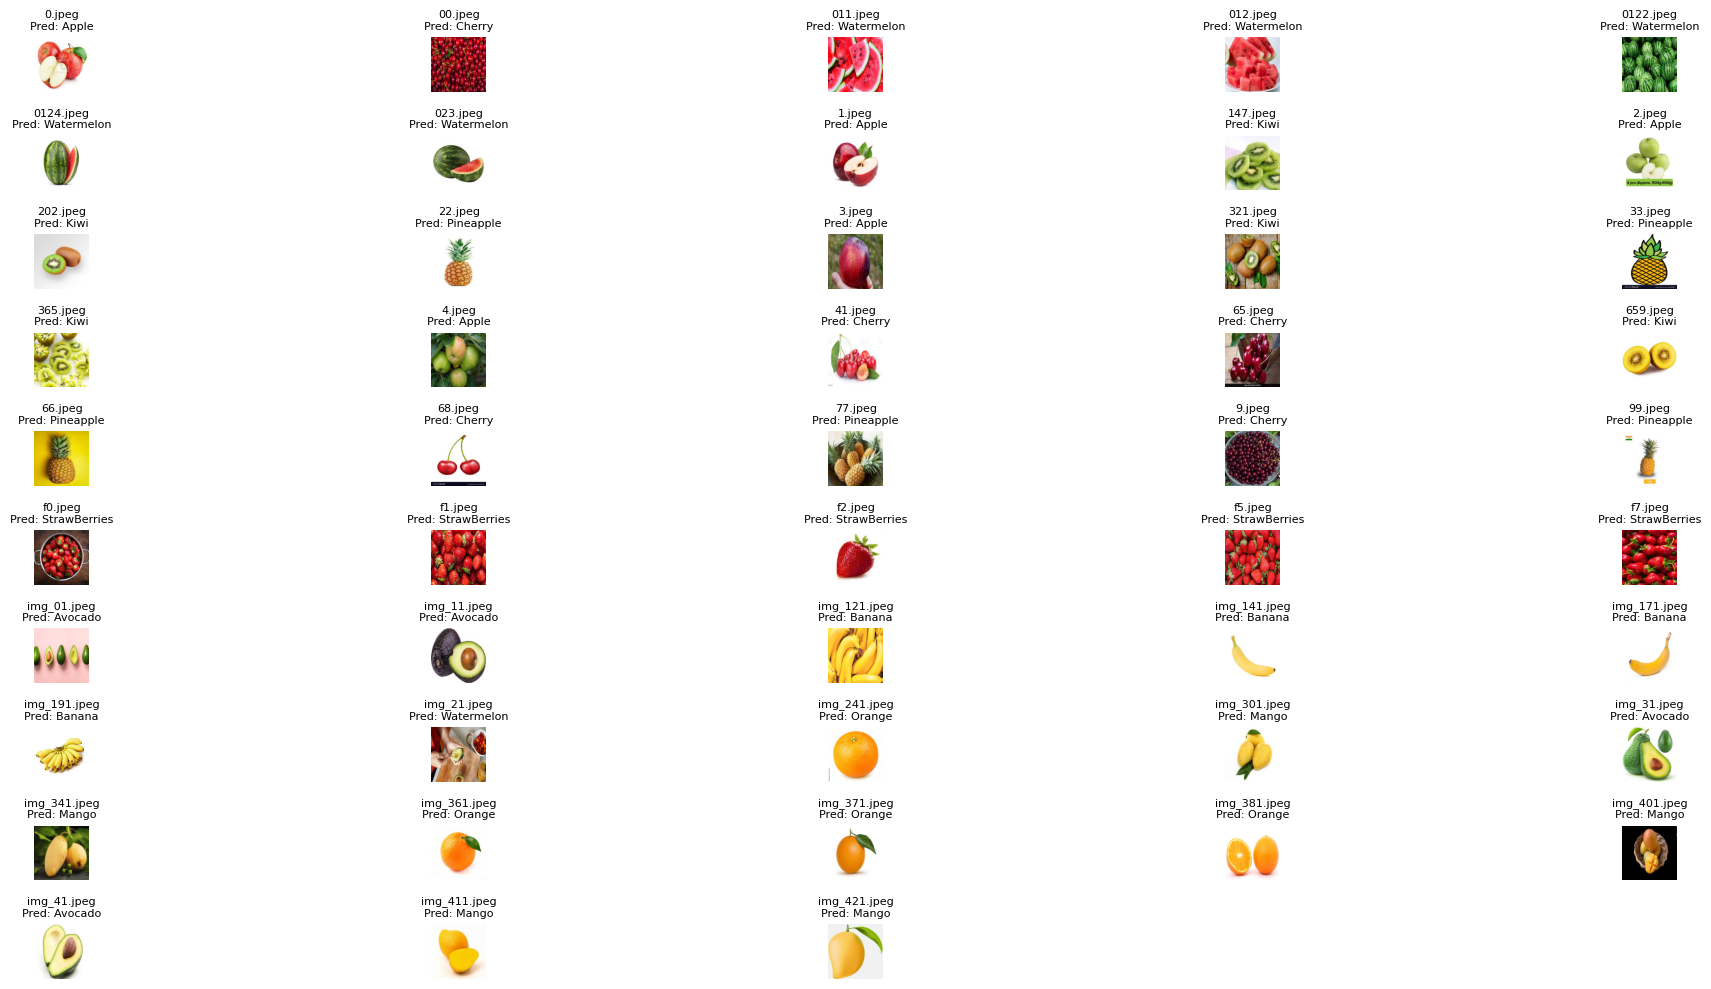

In [26]:
import os
from PIL import Image
import torch
from torchvision import transforms
import matplotlib.pyplot as plt

# Transformation used during model training
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) 
])

# Load images from the folder
images = []
image_paths = []
for file_name in sorted(os.listdir(predict_path)):
    file_path = os.path.join(predict_path, file_name)
    if file_name.lower().endswith(('png', 'jpg', 'jpeg', 'bmp', 'tiff')):
        image = Image.open(file_path).convert('RGB')
        images.append(transform(image))
        image_paths.append(file_name)

# Convert images to a batch tensor
images_tensor = torch.stack(images).to(device)

# Set the model to evaluation mode
model.eval()

# Get predictions
with torch.no_grad():
    outputs = model(images_tensor)
    _, predictions = torch.max(outputs, 1)

# Function to display predictions
def show_predictions(images, predictions, image_paths, class_names):
    num_to_display = len(images)   # Display all images
    plt.figure(figsize=(20, 10))
    for i in range(num_to_display):
        plt.subplot((num_to_display + 4) // 5, 5, i + 1)  
        
        # Denormalize for proper visualization
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        image = images[i].cpu() * std + mean
        
        # Ensure values are between 0 and 1
        plt.imshow(image.permute(1, 2, 0).clip(0, 1))
        plt.title(f'{image_paths[i]}\nPred: {class_names[predictions[i].item()]}', fontsize=8)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Assuming you have a dictionary or list `class_names` with class names
show_predictions(images, predictions, image_paths, class_names)


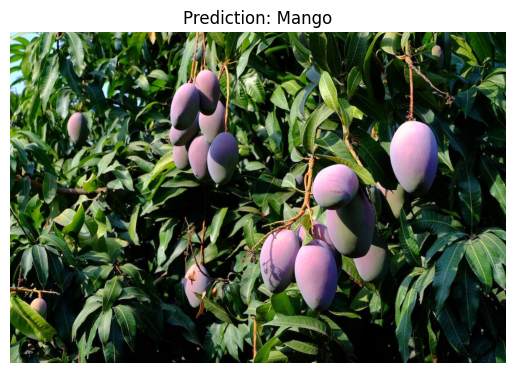

In [28]:
from io import BytesIO
import requests
from PIL import Image
import torch
from torchvision import transforms
import matplotlib.pyplot as plt

# Transformation used during model training
transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) 
])

def load_image_from_url(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert('RGB')
    return img

def predict_image(url, model, class_names):
    # Load image from URL
    image = load_image_from_url(url)

    # Apply transformation
    image_tensor = transform(image).unsqueeze(0).to(device)  # Add a batch dimension

    # Set model to evaluation mode
    model.eval()

    # Obtain predictions
    with torch.no_grad():
        outputs = model(image_tensor)
        _, prediction = torch.max(outputs, 1)

    # Display the image and the prediction
    plt.imshow(image)
    plt.title(f'Prediction: {class_names[prediction.item()]}')
    plt.axis('off')
    plt.show()

# Example usage
url = 'https://exoticfruitbox.com/wp-content/uploads/2015/10/DSCF0529-1024x683.jpg' 
predict_image(url, model, class_names)


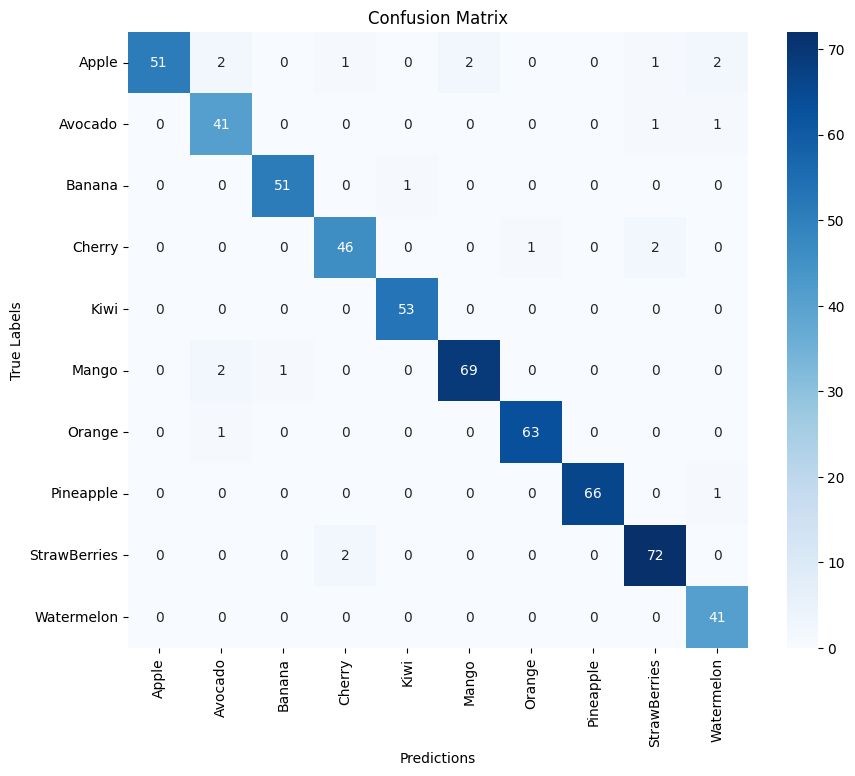

In [29]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

all_labels = []
all_predictions = []

# Set the model to evaluation mode
model.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        
        # Get the predictions
        _, predicted = torch.max(outputs.data, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Calculate the confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Create the confusion matrix plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predictions')
plt.ylabel('True Labels')
plt.show()
